In [30]:
import torch
import ignite
from ignite.engine import Engine, Events

import sys
sys.path.append('..')

from p3wgan.distributions import StandartNormalSampler, Mix8GaussiansSampler, DataLoaderWrapper
from p3wgan.utils import StatisticCollector
from p3wgan.models import ToyCritic, ToyMover, FullyConnectedMLP
import matplotlib.pyplot as plt
import seaborn as sns
from p3wgan.transport_costs import QuadraticTransportCost
from IPython.display import clear_output
sns.set()

### Make functions to launch

In [37]:
def prepare_batch(engine, i_batch):
    s = engine.state
    if i_batch % s.n_mover_steps == 0:
        # critic step
        s.mover_step = False
        batch = next(s.P_dl), next(s.Q_dl)
    else:
        # mover step
        s.mover_step=True
        batch = next(s.Q_dl)
    return batch
    

def update_model(engine, i_batch):
    s = engine.state
    batch = prepare_batch(engine, i_batch)
    if s.mover_step:
        s.mover_optim.zero_grad()
        moved_batch = s.mover(batch)
        loss = (s.gamma * s.cost(batch, moved_batch) - s.critic(moved_batch)).mean()
        loss.backward()
        s.mover_optim.step()
    else:
        s.critic_optim.zero_grad()
        P_batch, Q_batch = batch
        moved_batch = s.mover(Q_batch)
        loss = (s.critic(moved_batch) - s.critic(P_batch)).mean()
        loss.backward()
        s.critic_optim.step()
    return loss.item()

### Make trainter

In [44]:
device = 'cpu'
batch_size=1024
n_mover_steps = 5
critic_loss_n_averaging = 50
mover_loss_n_averaging = critic_loss_n_averaging * n_mover_steps
update_charts_freq = 200
learning_rate = 1e-4

In [45]:
trainer = Engine(update_model)

In [46]:
@trainer.on(Events.STARTED)
def initialize_state(engine):
    s = engine.state
    s.P_dl = iter(DataLoaderWrapper(StandartNormalSampler(
        dim=2, device=device, normalize=True), batch_size))
    s.Q_dl = iter(DataLoaderWrapper(Mix8GaussiansSampler(
        device=device, normalize=True), batch_size))
    s.n_mover_steps = n_mover_steps
    s.mover_loss = StatisticCollector(mover_loss_n_averaging)
    s.critic_loss = StatisticCollector(critic_loss_n_averaging)
    # initializing models
    s.critic = FullyConnectedMLP(2, [128, 128], 1, apply_batch_norm=True, device=device)
    s.mover = ToyMover(2, [128, 128], device=device)
    s.critic_optim = torch.optim.Adam(s.critic.parameters(), lr=learning_rate, betas=(0.0, 0.9))
    s.mover_optim = torch.optim.Adam(s.mover.parameters(), lr=learning_rate, betas=(0.0, 0.9)) 
    s.gamma = 1.
    s.cost = QuadraticTransportCost()


@trainer.on(Events.ITERATION_COMPLETED)
def log_loss(engine):
    s = engine.state
    if s.mover_step:
        s.mover_loss.add(s.output)
    else:
        s.critic_loss.add(s.output)

@trainer.on(Events.ITERATION_COMPLETED(every=update_charts_freq))
def show_loss(engine):
    clear_output(wait=True)
    s = engine.state
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    s.mover_loss.plot_statistic(axs[0], title='Mover Loss')
    s.critic_loss.plot_statistic(axs[1], title='Critic Loss')
    plt.show()

@trainer.on(Events.ITERATION_COMPLETED(every=update_charts_freq))
def show_transport(engine):
    s = engine.state
    s.mover.eval()
    batch_P, batch_Q = next(s.P_dl), next(s.Q_dl)
    moved_Q = s.mover(batch_Q).detach().cpu().numpy()
    batch_P = batch_P.detach().cpu().numpy()

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    axs[0].scatter(batch_P[:, 0], batch_P[:, 1], s=2.)
    axs[0].set_title('Original P')
    axs[1].scatter(moved_Q[:, 0], moved_Q[:, 1], s=2.)
    axs[1].set_title('Moved Q')
    plt.show()
    s.mover.train()


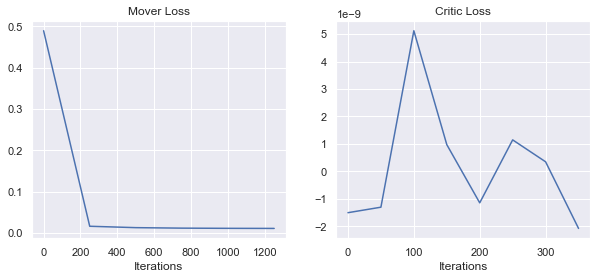

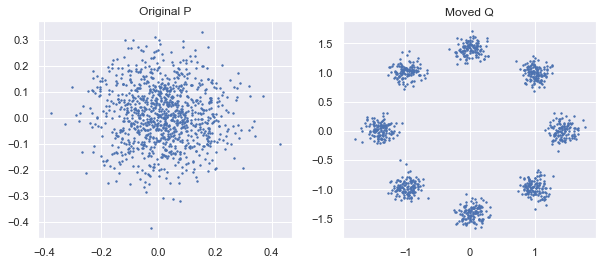

done


In [47]:
trainer.run(range(2000), max_epochs=1)
print('done')